In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import torch.nn.functional as F

In [32]:
class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(160 * 120, 2056)
        self.fc2 = nn.Linear(2056, 1028)
        self.fc3 = nn.Linear(1028, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 160 * 120)
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(76800, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Reshape for fully connected layer
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
class LightweightCNN(nn.Module):
    def __init__(self):
        super(LightweightCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1)
        self.fc1 = nn.Linear(17024, 512)
        self.fc2 = nn.Linear(512, 6)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Reshape for fully connected layer
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    

# Creating a CNN class
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(63936, 1024)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [33]:
model = ConvNeuralNet(num_classes=6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [34]:
# Import training and validation dataset from npz file
with np.load('/Users/jvelasquez/Virginia_Tech/Spring_2023/ECE_4806/ieee-robotics-2023-code/src/jetson_code/pedestal_classification/pedestal_color_orientation_dataset.npz') as data:
    print(data.files)
    images = data['images']
    labels = data['labels']

# Preprocess the images
images = images.astype('float32') / 255
print(images[0].shape)

# Make labels shape (n, 1)
#labels.reshape(labels.shape[0], 1)

# Convert the numpy arrays to PyTorch tensors
images_tensor = torch.from_numpy(images)
labels_tensor = torch.from_numpy(labels)

# Load the testing set
with np.load('/Users/jvelasquez/Virginia_Tech/Spring_2023/ECE_4806/ieee-robotics-2023-code/src/jetson_code/pedestal_classification/pedestal_color_orientation_test_dataset.npz') as data:
    print(data.files)
    test_images = data['images']
    test_labels = data['labels']

test_images = test_images.astype('float32') / 255
#test_labels = test_labels.reshape(test_labels.shape[0], 1)

# Shuffle test_images and test_labels together
p = np.random.permutation(len(test_images))
test_images = test_images[p]
test_labels = test_labels[p]

# Convert the numpy arrays to PyTorch tensors
test_images_tensor = torch.from_numpy(test_images)
test_labels_tensor = torch.from_numpy(test_labels)


['images', 'labels']
(3, 120, 160)
['images', 'labels']


In [35]:
# Define the dataset using the tensors
dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)

# Take a portion of the the test images and labels and append them to the dataset
portion = int(len(test_images_tensor) * 0.75)
dataset = torch.utils.data.ConcatDataset([dataset, torch.utils.data.TensorDataset(test_images_tensor[:portion], test_labels_tensor[:portion])])

# Take the other portion of the test images and labels and use them as the test set
other_portion = int(len(test_images_tensor) - portion)
test_set = torch.utils.data.TensorDataset(test_images_tensor[other_portion:], test_labels_tensor[other_portion:])

# Split the dataset into training, validation, and testing sets
train_split = 0.8
train_size = int(train_split * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

# test_set = torch.utils.data.TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [36]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
model.to(device)

print(model)

# # Input a dummy tensor to the model
# dummy_input = torch.randn(1, 3, 120, 160)
# out = model(dummy_input)
# print(out.shape)
# print(out)

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=63936, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=6, bias=True)
  (relu): ReLU()
)


Epoch [1/50], Train Loss: 1.7758, Train Acc: 27.99%, Val Loss: 1.7317, Val Acc: 55.04%, Test Loss: 1.7674, Test Acc: 46.74%
Epoch [2/50], Train Loss: 1.3695, Train Acc: 46.23%, Val Loss: 0.8090, Val Acc: 56.42%, Test Loss: 1.1710, Test Acc: 40.43%
Epoch [3/50], Train Loss: 0.8061, Train Acc: 56.13%, Val Loss: 0.6416, Val Acc: 63.10%, Test Loss: 0.8346, Test Acc: 57.60%
Epoch [4/50], Train Loss: 0.7091, Train Acc: 61.93%, Val Loss: 0.5655, Val Acc: 74.94%, Test Loss: 0.7604, Test Acc: 62.67%
Epoch [5/50], Train Loss: 0.6426, Train Acc: 66.56%, Val Loss: 0.5737, Val Acc: 69.77%, Test Loss: 0.7831, Test Acc: 59.98%
Epoch [6/50], Train Loss: 0.5809, Train Acc: 71.04%, Val Loss: 0.4461, Val Acc: 78.97%, Test Loss: 0.7332, Test Acc: 66.80%
Epoch [7/50], Train Loss: 0.4929, Train Acc: 76.11%, Val Loss: 0.3758, Val Acc: 86.02%, Test Loss: 0.6963, Test Acc: 69.49%
Epoch [8/50], Train Loss: 0.4313, Train Acc: 79.17%, Val Loss: 0.3360, Val Acc: 86.52%, Test Loss: 0.6504, Test Acc: 70.32%
Epoch [9

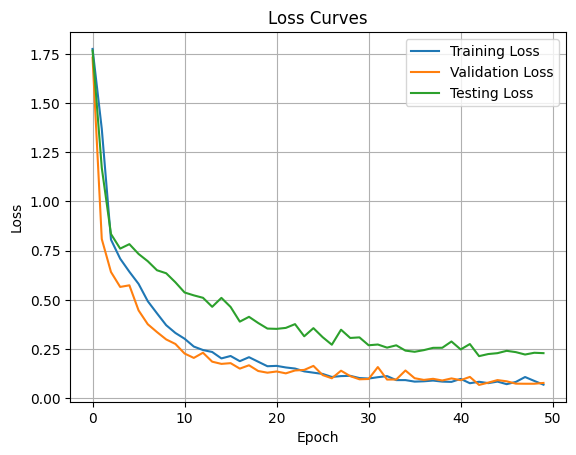

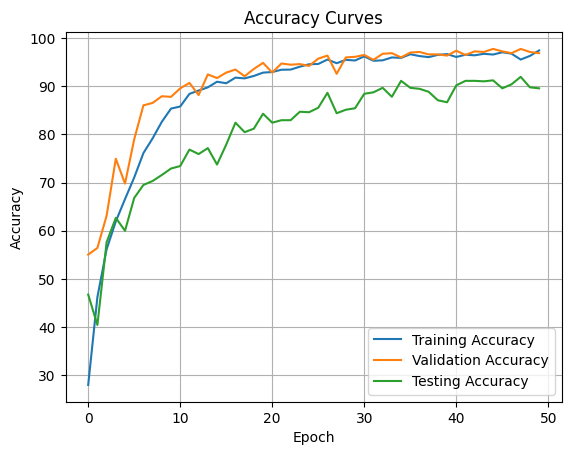

In [37]:
import matplotlib.pyplot as plt

num_epochs = 50

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
train_accs = []
val_losses = []
val_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader):

        # Send the data to mps
        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    #print(correct_train, total_train)
    train_acc = 100 * correct_train / total_train
    train_accs.append(train_acc)
    
    # Validate
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            # Send the data to mps
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accs.append(val_acc)
    
    # Test
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # Send the data to mps
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc = 100 * correct_test / total_test
    test_accs.append(test_acc)
    
    # Print statistics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
    
# Plot loss and accuracy curves for training, validation, and testing sets
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.plot(range(num_epochs), test_losses, label='Testing Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(range(num_epochs), train_accs, label='Training Accuracy')
plt.plot(range(num_epochs), val_accs, label='Validation Accuracy')
plt.plot(range(num_epochs), test_accs, label='Testing Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


In [38]:
# Save the model
torch.save(model.state_dict(), 'lightweight_net_color_orientation.pth')